In [1]:
from pprint import pprint
from tqdm import tqdm
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, roc_auc_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.utils.multiclass import unique_labels

pd.set_option('display.max_colwidth', None)

# Loading data

In [2]:
questions = pd.read_csv("./data/data.csv", delimiter=";")
answers = pd.read_csv("./data/train.csv", delimiter=";")

In [3]:
data = pd.merge(questions, answers, on="ID")

In [4]:
data["Question"] = data["Question"].astype("string")

# Analyzing data

In [5]:
print(data.shape)

(30000, 3)


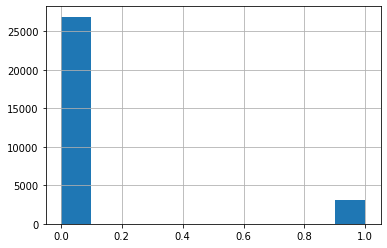

In [6]:
plt.grid(True)
plt.hist(data["Answer"])
plt.show()

In [7]:
display(data[data["Answer"] == 1].iloc[:10])

,ID,Question,Answer
1,2,Как в химии обозначается свинец?,1
5,6,Какая эра геологической истории Земли относится к настоящему времени?,1
8,9,Какой из этих мультфильмов повествует о реально существовавшей собаке?,1
20,21,"Как называется часть речи, обладающая свойствами глагола и прилагательного?",1
22,23,Когда была запущена «Википедия»?,1
41,42,Где находится яд у кобры?,1
45,46,Как зовут создателя паровой машины?,1
48,49,Сколько всего пальцев на лапах у кошек?,1
63,64,Сколько всего было выпущено серий сериала «Санта-Барбара»?,1
64,65,В каком году был поход Руси на Константинополь?,1


In [8]:
display(data[data["Answer"] == 0].iloc[:10])

,ID,Question,Answer
0,1,Как зовут лодочника на реке Стикс в древнегреческой мифологии?,0
2,3,Какой химический элемент преобладает в составе каменного угля?,0
3,4,Кто из перечисленных был пажом во времена Екатерины II?,0
4,5,Когда началась 2 мировая война?,0
6,7,Кто из животных может мурлыкать?,0
7,8,Что из перечисленного НЕ входит в национальную русскую кухню?,0
9,10,Кто написал повесть «Муму»,0
10,11,Что такое кульверт?,0
11,12,В какой воде меньше содержание примесей?,0
12,13,Сколько музыкантов в квинтете,0


In [9]:
X = data["Question"].to_numpy()
y = data["Answer"].to_numpy()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Solving task

In [11]:
cv=3
scoring=["accuracy", "roc_auc"]
refit="roc_auc"

In [12]:
results = {}
metrics = ["mean_test_" + score for score in scoring]

In [13]:
def get_results(gs):
    global results
    name = "__".join([step[0] for step in gs.estimator.steps])
    results[name] = {metric: round(gs.cv_results_[metric][gs.best_index_], 3) for metric in metrics}
    results[name] = results[name] | {"best_params": gs.best_params_}
    pprint(results[name])

In [14]:
def text_preprocess(x):
    #x = x[0]
    x = x.lower()
    x = re.sub(r'https*\S+', ' ', x)                           # mentions
    x = re.sub(r'@\S+', ' ', x)                                # links
    x = re.sub(r'#\S+', ' ', x)                                # hashtags
    x = re.sub(r'\'\w+', '', x)                                # ticks and the next character
    x = re.sub('[%s]' % re.escape(string.punctuation), ' ', x) # punctuation
    x = re.sub(r'\w*\d+\w*', '', x)                            # numbers
    x = re.sub(r'\s{2,}', ' ', x)                              # over spaces
    x = x.replace('\xad', '')                                  # \xad
    x = x.replace('\t', '')                                    # \t
    x = x.replace('№', '')                                     # \t
    return x

In [15]:
tfidfvectorizer__param_grid = {
    "tfidfvectorizer__ngram_range": [(1, n) for n in range(1, 3)],
    "tfidfvectorizer__max_features": [None, 100, 1000, 5000, 10000],
    "tfidfvectorizer__preprocessor": [text_preprocess, None]
}

## TfidfVectorizer -> MostCommonClassifier

In [16]:
class MostCommonClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, sample_param="kek"):
        self.sample_param = sample_param

    def fit(self, X, y):

        self.classes_ = unique_labels(y)
        unique, counts = np.unique(y, return_counts=True)
        self.frequency = dict(zip(unique, counts))
        self.probabilities = {}
        for k, v in self.frequency.items():
            self.probabilities[k] = v / sum(self.frequency.values())

        return self
    
    def decision_function(self, X):

        res = [0] * X.shape[0]
        
        return np.array(res)

    def predict(self, X):

        res = self.decision_function(X)
        res = [1 if pred > 0.5 else 0 for pred in res]
        
        return np.array(res)

In [17]:
pipeline = make_pipeline(TfidfVectorizer(), MostCommonClassifier())

param_grid = {}

gs = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, scoring=scoring, refit=refit, error_score="raise", n_jobs=-1)

In [18]:
gs.fit(X, y)

GridSearchCV(cv=3, error_score='raise',
             estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('mostcommonclassifier',
                                        MostCommonClassifier())]),
             n_jobs=-1, param_grid={}, refit='roc_auc',
             scoring=['accuracy', 'roc_auc'])

In [19]:
get_results(gs)

{'best_params': {}, 'mean_test_accuracy': 0.896, 'mean_test_roc_auc': 0.5}


## TfidfVectorizer -> ProbabilityClassifier

In [20]:
class ProbabilityClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, sample_param="kek"):
        self.sample_param = sample_param

    def fit(self, X, y):

        self.classes_ = unique_labels(y)
        unique, counts = np.unique(y, return_counts=True)
        self.frequency = dict(zip(unique, counts))
        self.probabilities = {}
        for k, v in self.frequency.items():
            self.probabilities[k] = v / sum(self.frequency.values())

        return self

    def decision_function(self, X):

        res = []
        for row in X:
            res.append(np.random.choice(list(self.probabilities.keys()), p=list(self.probabilities.values())))
        
        return np.array(res)
    
    def predict(self, X):

        res = self.decision_function(X)
        res = [1 if pred > 0.5 else 0 for pred in res]
        
        return np.array(res)

In [21]:
pipeline = make_pipeline(TfidfVectorizer(), ProbabilityClassifier())

param_grid = {}

gs = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, scoring=scoring, refit=refit, error_score="raise", n_jobs=-1)

In [22]:
gs.fit(X, y)

GridSearchCV(cv=3, error_score='raise',
             estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('probabilityclassifier',
                                        ProbabilityClassifier())]),
             n_jobs=-1, param_grid={}, refit='roc_auc',
             scoring=['accuracy', 'roc_auc'])

In [23]:
get_results(gs)

{'best_params': {}, 'mean_test_accuracy': 0.817, 'mean_test_roc_auc': 0.505}


## TfidfVectorizer -> LogisticRegression

In [24]:
pipeline = make_pipeline(TfidfVectorizer(),
                         LogisticRegression())

logisticregression__param_grid = {
    "logisticregression__class_weight": [None, "balanced"]
}

param_grid = tfidfvectorizer__param_grid | logisticregression__param_grid

gs = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, scoring=scoring, refit=refit, error_score="raise", n_jobs=-1)

In [ ]:
gs.fit(X, y)

In [ ]:
get_results(gs)

# Results

In [ ]:
info = pd.DataFrame.from_dict(results, orient="index").sort_values(by="mean_test_roc_auc", ascending=False)
display(info)